In [16]:
from transformers import BlipProcessor, BlipForConditionalGeneration
import torch.nn as nn
import torch.nn.functional as F
import torch
from torch.utils.data import DataLoader, TensorDataset

import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import random
import time

from PIL import Image


In [22]:
# Load pre-trained models
processor = BlipProcessor.from_pretrained("Salesforce/blip-image-captioning-large")
model = BlipForConditionalGeneration.from_pretrained("Salesforce/blip-image-captioning-large")

In [4]:
print(model)

BlipForConditionalGeneration(
  (vision_model): BlipVisionModel(
    (embeddings): BlipVisionEmbeddings(
      (patch_embedding): Conv2d(3, 1024, kernel_size=(16, 16), stride=(16, 16))
    )
    (encoder): BlipEncoder(
      (layers): ModuleList(
        (0): BlipEncoderLayer(
          (self_attn): BlipAttention(
            (dropout): Dropout(p=0.0, inplace=False)
            (qkv): Linear(in_features=1024, out_features=3072, bias=True)
            (projection): Linear(in_features=1024, out_features=1024, bias=True)
          )
          (layer_norm1): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
          (mlp): BlipMLP(
            (activation_fn): GELUActivation()
            (fc1): Linear(in_features=1024, out_features=4096, bias=True)
            (fc2): Linear(in_features=4096, out_features=1024, bias=True)
          )
          (layer_norm2): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
        )
        (1): BlipEncoderLayer(
          (self_attn): BlipAtte

In [3]:
# Extract vision model which includes both embeddings and encoder
base_vision_model = model.vision_model

In [6]:
print(base_vision_model)

BlipVisionModel(
  (embeddings): BlipVisionEmbeddings(
    (patch_embedding): Conv2d(3, 1024, kernel_size=(16, 16), stride=(16, 16))
  )
  (encoder): BlipEncoder(
    (layers): ModuleList(
      (0): BlipEncoderLayer(
        (self_attn): BlipAttention(
          (dropout): Dropout(p=0.0, inplace=False)
          (qkv): Linear(in_features=1024, out_features=3072, bias=True)
          (projection): Linear(in_features=1024, out_features=1024, bias=True)
        )
        (layer_norm1): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
        (mlp): BlipMLP(
          (activation_fn): GELUActivation()
          (fc1): Linear(in_features=1024, out_features=4096, bias=True)
          (fc2): Linear(in_features=4096, out_features=1024, bias=True)
        )
        (layer_norm2): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
      )
      (1): BlipEncoderLayer(
        (self_attn): BlipAttention(
          (dropout): Dropout(p=0.0, inplace=False)
          (qkv): Linear(in_featu

In [4]:
class CatClassifier(nn.Module):
    def __init__(self, base_vision_model):
        super(CatClassifier, self).__init__()
        self.base_vision_model = base_vision_model
        self.fc = nn.Linear(in_features=1024, out_features=256) # Assuming 1024 is the size of the encoder's output based on the structure.
        self.output = nn.Linear(256, 3)
        
    def forward(self, pixel_values, attention_mask=None, **kwargs):
        # Get the base vision model's output
        vision_outputs = self.base_vision_model(pixel_values, attention_mask, **kwargs)
        
        # Depending on the exact output structure of the vision model, 
        # you may need to modify the next line to get the appropriate representation.
        # For this example, let's assume you get the last hidden state similar to other transformers.
        pooled_output = vision_outputs.last_hidden_state[:, 0]
        
        # Pass through the dense layer and the output layer
        x = F.leaky_relu(self.fc(pooled_output), negative_slope=0.1)
        x = self.output(x)
        
        return x



In [5]:
# Instantiate the new model
cat_classifier = CatClassifier(base_vision_model)

In [6]:
# Define your data directory
data_dir = 'images/'

# Find the minimum number of images across all subdirectories
min_images = float('inf')
for class_dir in os.listdir(data_dir):
    class_path = os.path.join(data_dir, class_dir)
    if os.path.isdir(class_path):
        num_images = len(os.listdir(class_path))
        min_images = min(min_images, num_images)

# Initialize lists to store images and labels
images = []
labels = []

# Loop through subdirectories (each subdirectory corresponds to a class)
for class_dir in os.listdir(data_dir):
    class_path = os.path.join(data_dir, class_dir)
    if os.path.isdir(class_path):
        images_added = 0
        for img_filename in os.listdir(class_path):
            if images_added < min_images:  # Only load up to the minimum number
                img_path = os.path.join(class_path, img_filename)
                # Read the image and resize it to your desired size
                img = cv2.imread(img_path)
                img = cv2.resize(img, (224, 224))  # Adjust the size as needed
                
                # Convert BGR image to RGB
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                
                images.append(img)
                labels.append(class_dir)
                images_added += 1

# Convert the labels to numerical format
label_encoder = LabelEncoder()
labels = label_encoder.fit_transform(labels)

# Split the data into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(np.array(images), np.array(labels), test_size=0.2, random_state=42)

In [7]:
# Convert numpy data to PyTorch tensors
x_train_tensor = torch.tensor(x_train).permute(0, 3, 1, 2).float() # Change the data layout suitable for PyTorch: (batch_size, channels, height, width)
y_train_tensor = torch.tensor(y_train)

x_test_tensor = torch.tensor(x_test).permute(0, 3, 1, 2).float()
y_test_tensor = torch.tensor(y_test)

# Create TensorDatasets and DataLoaders
train_dataset = TensorDataset(x_train_tensor, y_train_tensor)
test_dataset = TensorDataset(x_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32)

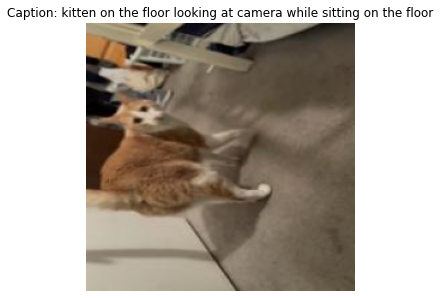

In [32]:
def caption_and_display(model, images, processor):
    # Ensure images is a list for consistent processing
    if isinstance(images, np.ndarray):
        images = [images]

    captions = []

    # Generate captions for each image
    for img in images:
        img_tensor = torch.tensor(img).unsqueeze(0).permute(0, 3, 1, 2).float()
        inputs = processor(img_tensor, return_tensors="pt")
        out = model.generate(**inputs, max_new_tokens=50, temperature=0.5, do_sample=True)
        captions.append(processor.decode(out[0], skip_special_tokens=True))

    # Display images with their captions
    num_images = len(images)
    plt.figure(figsize=(12, 12))
    for i in range(num_images):
        plt.subplot(3, 3, i + 1)
        plt.imshow(images[i])
        plt.title(f'Caption: {captions[i]}')
        plt.axis('off')

    plt.tight_layout()
    plt.show()


test_image = x_test[0]
# print(test_image.shape)
caption_and_display(model, test_image, processor)

In [8]:
criterion = nn.CrossEntropyLoss() # For classification tasks with multiple classes
optimizer = torch.optim.Adam(cat_classifier.parameters(), lr=0.005)

In [10]:
num_epochs = 2

train_accuracies = []
val_accuracies = []
epoch_start_time = time.time()
for epoch in range(num_epochs):
    cat_classifier.train()
    correct_train = 0
    total_train = 0
    # Starting the timer for the epoch
    
    for batch_idx, (images, labels) in enumerate(train_loader):
        print(f'{batch_idx}/{len(train_loader)}')
        start_time = time.time()
        optimizer.zero_grad()

        outputs = cat_classifier(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        _, predicted_train = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted_train == labels).sum().item()

        # Print progress  (you can adjust this number)
        elapsed_time = time.time() - start_time
        print(f'Batch time: {elapsed_time}')
        print(f'Epoch [{epoch+1}/{num_epochs}], Batch [{batch_idx+1}/{train_loader}], Loss: {loss.item():.4f}')

    epoch_elapsed_time = time.time() - start_time
    print(f'Epoch time: {epoch_elapsed_time}')
    train_acc = correct_train / total_train
    train_accuracies.append(train_acc)
    
    # Validation
    cat_classifier.eval()
    correct_val = 0
    total_val = 0
    with torch.no_grad():
        for batch in test_loader:
            start_time = time.time()
            images, labels = batch
            outputs = cat_classifier(images)
            _, predicted_val = torch.max(outputs.data, 1)
            total_val += labels.size(0)
            correct_val += (predicted_val == labels).sum().item()
            elapsed_time = time.time() - start_time
            print(f'Batch time: {elapsed_time}')

    val_acc = correct_val / total_val
    val_accuracies.append(val_acc)
    
    print(f"Epoch [{epoch+1}/{num_epochs}], Training Accuracy: {train_acc*100:.2f}%, Validation Accuracy: {val_acc*100:.2f}%")


0/13
Batch time: 141.88197541236877
Epoch [1/2], Batch [1/2], Loss: 3.7464
1/13
Batch time: 114.02315759658813
Epoch [1/2], Batch [2/2], Loss: 5.5029
2/13
Batch time: 111.43113160133362
Epoch [1/2], Batch [3/2], Loss: 7.6568
3/13
Batch time: 114.44401049613953
Epoch [1/2], Batch [4/2], Loss: 1.5475
4/13
Batch time: 115.72670912742615
Epoch [1/2], Batch [5/2], Loss: 1.3903
5/13
Batch time: 117.75287008285522
Epoch [1/2], Batch [6/2], Loss: 1.2735
6/13
Batch time: 118.7607638835907
Epoch [1/2], Batch [7/2], Loss: 1.1115
7/13
Batch time: 119.09631633758545
Epoch [1/2], Batch [8/2], Loss: 1.2049
8/13
Batch time: 130.05412888526917
Epoch [1/2], Batch [9/2], Loss: 4.1344
9/13
Batch time: 117.12913155555725
Epoch [1/2], Batch [10/2], Loss: 1.1675
10/13
Batch time: 111.35722374916077
Epoch [1/2], Batch [11/2], Loss: 1.1305
11/13
Batch time: 109.08981490135193
Epoch [1/2], Batch [12/2], Loss: 1.1407
12/13
Batch time: 75.90232348442078
Epoch [1/2], Batch [13/2], Loss: 1.0985
Epoch time: 75.93933

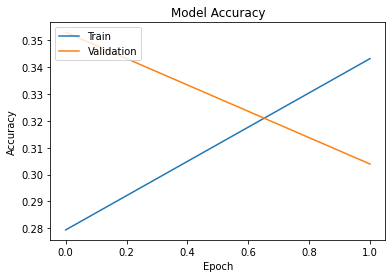

In [11]:
plt.plot(train_accuracies)
plt.plot(val_accuracies)
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

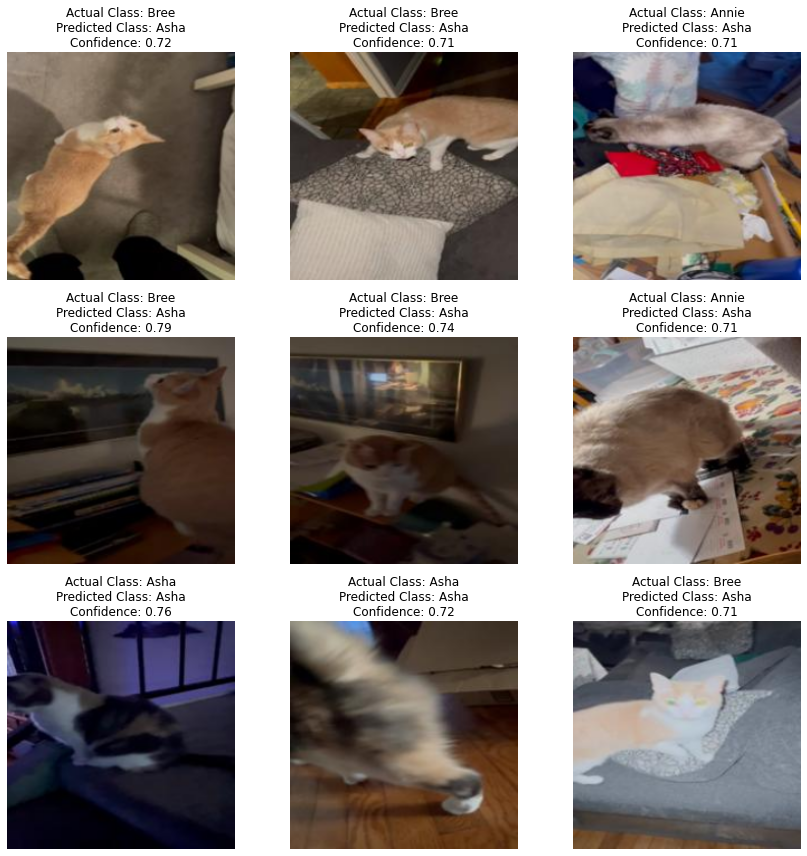

In [14]:
def predict_and_display(model, images, actual_labels, class_names):
    # Convert numpy images to PyTorch tensors and adjust layout
    images_tensor = torch.tensor(images).permute(0, 3, 1, 2).float()
    
    # Ensure model is in evaluation mode and make predictions
    model.eval()
    with torch.no_grad():
        predictions = model(images_tensor).numpy()

    # Get the predicted classes and their associated confidence scores
    predicted_classes = np.argmax(predictions, axis=1)
    confidence_scores = np.max(predictions, axis=1)

    # Display the images, actual class, and predicted class
    num_images = len(images)
    
    plt.figure(figsize=(12, 12))
    for i in range(num_images):
        plt.subplot(3, 3, i + 1)
        plt.imshow(images[i])
        plt.title(f'Actual Class: {class_names[actual_labels[i]]}\nPredicted Class: {class_names[predicted_classes[i]]}\nConfidence: {confidence_scores[i]:.2f}')
        plt.axis('off')

    plt.tight_layout()
    plt.show()

# Assuming `class_names` is a list of class names corresponding to indices
class_names = ["Annie", "Asha", "Bree"]

# Randomly select 9 images from x_test for prediction
random_indices = np.random.choice(len(x_test), 9, replace=False)
random_images = x_test[random_indices]  # Ensure these are properly normalized
actual_labels = y_test[random_indices]  # Actual class indices

# Make predictions and display the results
predict_and_display(cat_classifier, random_images, actual_labels, class_names)


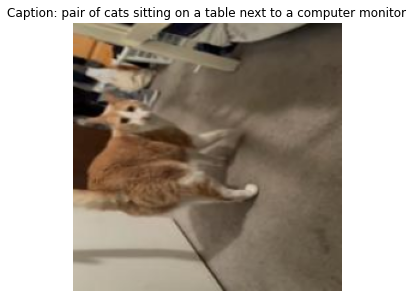

In [34]:
test_image = x_test[0]
# print(test_image.shape)
caption_and_display(model, test_image, processor)